<a href="https://colab.research.google.com/github/MaricelaMH/SIMULACION-II/blob/main/Ejem_Peluqueria_Linea_de_espera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install simpy

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from random import random, seed
import pandas as pd
import simpy

In [3]:
def peluqueria(env, pelucas, nc, texto=True):
    global  ll, cifras, dur_corte, t_esp, fin_sim, LTLL, LC, LS

    for i in range(nc):
        #Llegada del cliente
        r = random()
        tll = -np.log(r)/ll
        yield env.timeout(tll)
        LTLL.append(env.now)
        if texto:
          print(f'----Ha llegado el cliente número {i} en el minuto {round(env.now, cifras)}----')

        env.process(corte(env, pelucas, i, texto))

In [4]:
def corte(env, pelucas, num, texto=True):
    global tc_min, tc_max, cifras, dur_corte, LC, LS
    a, b = tc_min, tc_max
    #Solicitud del corte
    with pelucas.request() as sol:
        yield sol

        #Inicia el corte

        #Se genera el tiempo de corte
        r = random()
        tc = a + (b-a)*r
        dur_corte += tc
        LC.append(tc)
        if texto:
          print(f'****Inicia el corte del cliente {num} en el minuto {round(env.now, cifras)}****')
        #Se suma el tiempo a la line ade tiempo actual
        yield env.timeout(tc)

        #Muestra un mensaje al término del corte
        LS.append(env.now)
        if texto:
          print(f'xxxTermina el corte del cliente {num} en el minuto {round(env.now, cifras)}xxx')
        return tc

In [5]:
global tc_min, tc_max, ll, no_peluqueros, cifras
semilla = 13
seed(semilla)

no_peluqueros = 1
tc_min = 15
tc_max = 30
ll = 1/20
clientes = 5
cifras = 2

In [6]:
global t_esp, dur_corte, fin_sim, LTLL, LC, LS
t_esp = 0
dur_corte = 0
fin_sim = 0

LTLL, LC, LS = [], [], []

In [7]:
ent = simpy.Environment()
pelucas = simpy.Resource(ent, capacity=no_peluqueros)

In [8]:
ent.process(peluqueria(ent, pelucas, clientes))

<Process(peluqueria) object at 0x7f2efb563c10>

In [9]:
ent.run()

----Ha llegado el cliente número 0 en el minuto 27.02----
****Inicia el corte del cliente 0 en el minuto 27.02****
----Ha llegado el cliente número 1 en el minuto 34.58----
----Ha llegado el cliente número 2 en el minuto 37.84----
xxxTermina el corte del cliente 0 en el minuto 52.28xxx
****Inicia el corte del cliente 1 en el minuto 52.28****
xxxTermina el corte del cliente 1 en el minuto 70.74xxx
****Inicia el corte del cliente 2 en el minuto 70.74****
----Ha llegado el cliente número 3 en el minuto 71.51----
xxxTermina el corte del cliente 2 en el minuto 87.94xxx
****Inicia el corte del cliente 3 en el minuto 87.94****
----Ha llegado el cliente número 4 en el minuto 101.33----
xxxTermina el corte del cliente 3 en el minuto 113.96xxx
****Inicia el corte del cliente 4 en el minuto 113.96****
xxxTermina el corte del cliente 4 en el minuto 130.91xxx


In [10]:
LTLL, LC, LS = np.array(LTLL), np.array(LC), np.array(LS)
t_esp = sum(LS - LTLL - LC)
fin_sim = ent.now

In [11]:
print(LTLL)
print(LC)
print(LS)
print(t_esp, dur_corte, fin_sim)

[ 27.01788863  34.57708622  37.84309064  71.51294348 101.3315631 ]
[25.26122877 18.45837913 17.20739877 26.01035403 16.95319534]
[ 52.2791174   70.73749653  87.9448953  113.95524934 130.90844468]
79.65207512522942 103.8905560518379 130.9084446773146


In [12]:
print(f'Longitud promedio de la cola (fila): {round(t_esp/fin_sim, 2)} personas en cola')
print(f'Tiempo de espera promedio: {round(t_esp/clientes,2)} minutos')
print(f'Uso promedio de la instalación: {round(100 * dur_corte/fin_sim,2)}%')

Longitud promedio de la cola (fila): 0.61 personas en cola
Tiempo de espera promedio: 15.93 minutos
Uso promedio de la instalación: 79.36%


In [13]:
def exp(n):
  global tc_min, tc_max, ll, no_peluqueros, t_esp, dur_corte, fin_sim, LTLL, LC, LS

  no_peluqueros = 1
  tc_min = 15
  tc_max = 30
  ll = 1/20
  clientes = 5
  cifras = 2

  long_cola = []
  tiempo_esp = []
  uso = []

  for _ in range(n):
    t_esp = 0
    dur_corte = 0
    fin_sim = 0

    LTLL, LC, LS = [], [], []

    ent = simpy.Environment()
    pelucas = simpy.Resource(ent, capacity=no_peluqueros)
    ent.process(peluqueria(ent, pelucas, clientes, texto=False))
    ent.run()
    LTLL, LC, LS = np.array(LTLL), np.array(LC), np.array(LS)
    t_esp = sum(LS - LTLL - LC)
    fin_sim = ent.now

    long_cola.append(t_esp/fin_sim)
    tiempo_esp.append(t_esp/clientes)
    uso.append(100 * dur_corte/fin_sim)

  return long_cola, tiempo_esp, uso

In [14]:
n = 500
a, b, c = exp(n)

In [15]:
def graf_estado(l, titulo):
  g = []
  n = len(l)
  for i in range(n):
    g.append(np.mean(l[:i+1]))
  plt.plot(g, 'lightblue')
  m = np.mean(l)
  s = np.std(l, ddof=1)
  plt.hlines(m, 0, n, color='r', linestyles='dotted')
  plt.hlines(m + 1.96*np.std(l)/np.sqrt(n), 0, n, color='g', linestyles='dashed')
  plt.hlines(m - 1.96*np.std(l)/np.sqrt(n), 0, n, color='g', linestyles='dashed')
  plt.title(titulo)
  plt.xlabel('iteraciones')
  plt.show()

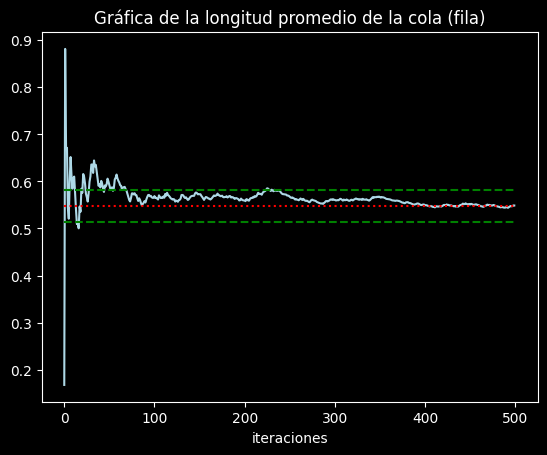

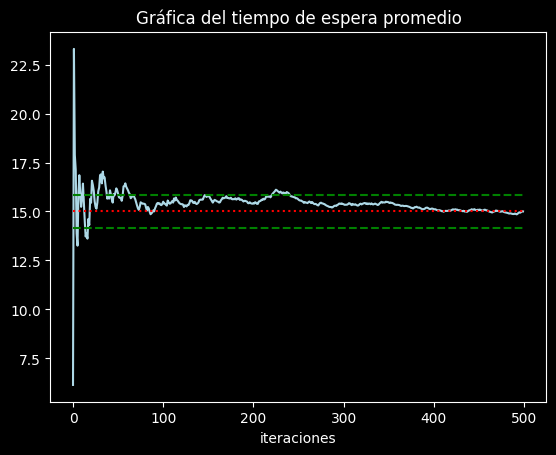

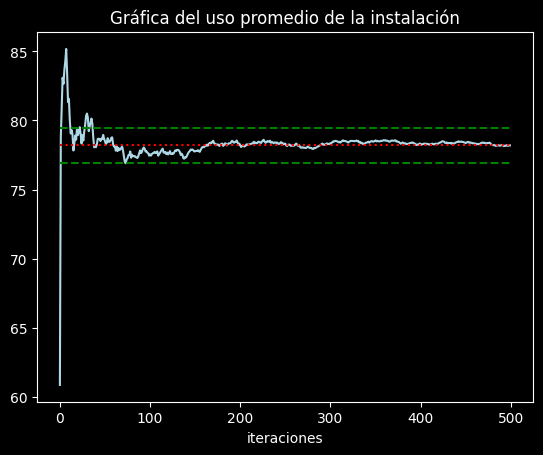

In [16]:
plt.style.use('dark_background')
graf_estado(a, 'Gráfica de la longitud promedio de la cola (fila)')
graf_estado(b, 'Gráfica del tiempo de espera promedio')
graf_estado(c, 'Gráfica del uso promedio de la instalación')

In [17]:
def rep(n, nr):
  la, lb, lc = [], [], []
  for _ in range(nr):
    a, b, c = exp(n)
    la.append(np.mean(a))
    lb.append(np.mean(b))
    lc.append(np.mean(c))
  return la, lb, lc

In [18]:
n = 500
nr = 100
a, b, c = rep(n, nr)

In [19]:
from scipy.stats import t
ma, mb, mc = np.mean(a), np.mean(b), np.mean(c)
sa, sb, sc = np.std(a, ddof=1), np.std(b, ddof=1), np.std(c, ddof=1)
t_student = t.ppf(0.975, nr-1)
# print(t_student)
intervalo_a = (ma - t_student*sa/np.sqrt(nr), ma + t_student*sa/np.sqrt(nr))
intervalo_b = (mb - t_student*sb/np.sqrt(nr), mb + t_student*sb/np.sqrt(nr))
intervalo_c = (mc - t_student*sc/np.sqrt(nr), mc + t_student*sc/np.sqrt(nr))
dec = 5

In [20]:
print(f'El intervalo de confianza al 95% de la longitud promedio de la cola (fila): {np.round(intervalo_a, dec)} personas en cola')
print(f'El intervalo de confianza al 95% del tiempo de espera promedio: {np.round(intervalo_b, dec)} minutos')
print(f'El intervalo de confianza al 95% del uso promedio de la instalación: {np.round(intervalo_c, dec)}%')

El intervalo de confianza al 95% de la longitud promedio de la cola (fila): [0.54434 0.55112] personas en cola
El intervalo de confianza al 95% del tiempo de espera promedio: [15.01376 15.1763 ] minutos
El intervalo de confianza al 95% del uso promedio de la instalación: [77.72479 77.98604]%
